In [951]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [952]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()




### Preprocessing delle variabili

Mapping variabile target

In [953]:

y = np.array(pp_class['titleType'])  # Il target originale


# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
## pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

y_map # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'videoGame': 1,
 'movie': 2,
 'tvSeries': 3,
 'video': 4,
 'tvMiniSeries': 5,
 'short': 6,
 'tvMovie': 7,
 'tvSpecial': 8,
 'tvShort': 9}

##### info variabili

In [954]:
#studio variabili (non ho messo le 28 is_genere)
pp_class[['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes', 'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins', 'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
          #'countryOfOrigin', 
       'fill_runtimeMinutes', 'titleType_encoded']].head(3)

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,fill_runtimeMinutes,titleType_encoded
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,1,tvEpisode,0,False,0,1,0,40.0,0
1,Looping,6,1982,1982.0,NaN,0.0,11,1,0,1,0,videoGame,0,False,0,1,0,28.0,1
2,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,0,movie,0,False,0,1,1,90.0,2


In [955]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1

In [956]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
##pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [957]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
##pp_test_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> tolto finchè non capiamo come gestirlo

In [958]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE SE GIà SOSTITUITO

#OPPURE RIMUOVI
pp_class= pp_class.drop(["endYear"], axis=1)
##pp_test_class= pp_class.drop(["endYear"], axis=1)

BINARIZZAZIONE -> da capire

In [ ]:

#1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)
pp_class['awardWins_bin'] = (pp_class['awardWins'] > 0).astype(int)
pp_class['totalVideos_bin'] = (pp_class['totalVideos'] > 0).astype(int)
pp_class['awardNominationsExcludeWins_bin'] = (pp_class['awardNominationsExcludeWins'] > 0).astype(int)

# pp_test_class['awardWins_bin'] = (pp_test_class['awardWins'] > 0).astype(int)
# pp_test_class['totalVideos_bin'] = (pp_test_class['totalVideos'] > 0).astype(int)
# pp_test_class['awardNominationsExcludeWins_bin'] = (pp_test_class['awardNominationsExcludeWins'] > 0).astype(int)


In [ ]:
#2 discretizzazione per fasce -> decise con 
#pp_class['awardNominationsExcludeWins'].value_counts().sort_index()

In [961]:
# bins_awards = [0, 1, 10, float('inf')]
# labels_awards = [0, 1, 2]  # Mantengo valori numerici per compatibilità con algoritmi
# pp_class['awardWins_bin'] = pd.cut(pp_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)
# ## pp_test_class['awardWins_bin'] = pd.cut(pp_test_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)



# bins_videos = [0, 1, 6, float('inf')]
# labels_videos = [0, 1, 2]
# pp_class['totalVideos_bin'] = pd.cut(pp_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)
# ## pp_test_class['totalVideos_bin'] = pd.cut(pp_test_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)



# bins_nom = [0, 1, 5, float('inf')]
# labels_nom = [0, 1, 2]
# pp_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_class['awardNominationsExcludeWins'], 
#                                                     bins=bins_nom, 
#                                                     labels=labels_nom, 
#                                                     right=False)
# ## pp_train_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_train_class['awardNominationsExcludeWins'], 
# #                                                    bins=bins_nom, 
# #                                                    labels=labels_nom, 
# #                                                    right=False)



# # Assicurati che le nuove colonne siano di tipo numerico
# pp_class['awardWins_bin'] = pp_class['awardWins_bin'].astype(int)
# pp_class['totalVideos_bin'] = pp_class['totalVideos_bin'].astype(int)
# pp_class['awardNominationsExcludeWins_bin'] = pp_class['awardNominationsExcludeWins_bin'].astype(int)

# ## pp_test_class['awardWins_bin'] = pp_test_class['awardWins_bin'].astype(int)
# ## pp_test_class['totalVideos_bin'] = pp_test_class['totalVideos_bin'].astype(int)
# ## pp_test_class['awardNominationsExcludeWins_bin'] = pp_test_class['awardNominationsExcludeWins_bin'].astype(int)


### !! DIVERSO DA GAIA (1,5,6,9)--> Filtra dataset su classi meno rappresentate ->"tvMovie": 7, "tvSpecial":8, "tvShort":9

In [962]:
#pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

Encoding di titletype per multiclass classification task

In [963]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
## y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

####  creazione array di valori -> da cui scegliere feature da usare

In [964]:
#X_train = pp_class.values
X_train = pp_class[[
       #'rating', #cambia poco
       'startYear',  #forse lasciare, sempre 77a ma aiuta a classificare una classe in + 
       'numVotes', 
       #'totalImages', #Peggiora poco
       'totalCredits', 
       'criticReviewsTotal',
       'canHaveEpisodes', 
       #'isAdult', peggiora molto
       #'numRegions', 
       'userReviewsTotal', 
       #'endYear',
       #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
       'fill_runtimeMinutes', #da tenere
       #'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
       #'awardWins_bin',  
       #'totalVideos_bin', 
       #'awardNominationsExcludeWins_bin' #-> PEGGIORA ABB
       ]].values

## X_test = pp_test_class[[ ]].values

In [965]:
# #TOGLIENDO 7,8,9 OPZIONE MIGLIORE -> in realtà anche con le classi
# X_train = pp_class[[
#        'startYear',  
#        'numVotes', 
#        'totalCredits', 
#        'criticReviewsTotal',
#        'canHaveEpisodes',  
#        'userReviewsTotal', 
#        'fill_runtimeMinutes'
#        ]].values

### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [966]:


X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)


# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

In [967]:
print(X_train2.shape, X_val.shape, X_train.shape
      #, X_test.shape
      )

(13144, 7) (3287, 7) (16431, 7)


### Normalization

In [968]:
X_train2_log = np.log1p(X_train2)
X_val_log= np.log1p(X_val)

## X_train_log = np.log1p(X_train)
## X_test_log = np.log1p(X_test)

In [969]:

standardsc = StandardScaler()

        # # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

## X_train_standardsc = standardsc.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
## X_test_standardsc = standardsc.transform(X_test_log)

In [970]:
# minmax = MinMaxScaler()

        ## Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)

## X_train_minmax = minmax.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)



In [971]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

## X_train_tr = X_train_standardsc
## X_test_tr = X_test_standardsc

## NAIVE BAYES

In [972]:
clf = GaussianNB()

In [973]:
clf.fit(X_train2_tr, y_train2)

GaussianNB()

Predicting on validation set

In [974]:
y_pred = clf.predict(X_val_tr)
y_pred

array([3, 4, 2, ..., 3, 0, 6], dtype=int64)

In [975]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3287
3287


In [976]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [977]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.7730453300882264

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       936
           1       0.86      0.64      0.74        50
           2       0.80      0.86      0.83      1121
           3       0.89      0.97      0.93       268
           4       0.32      0.29      0.30       163
           5       0.43      0.16      0.24        37
           6       0.81      0.85      0.83       501
           7       0.21      0.02      0.03       173
           8       0.25      0.04      0.06        28
           9       0.00      0.00      0.00        10

    accuracy                           0.77      3287
   macro avg       0.53      0.47      0.48      3287
weighted avg       0.73      0.77      0.75      3287



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tvEpisode': 0,  'movie': 2, 'tvSeries': 3, 'video': 4,  'short': 6, 'tvMovie': 7, }
tolti -> 'videoGame': 1, 'tvMiniSeries': 5,'tvSpecial': 8, 'tvShort': 9

In [978]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [3.29937656e-002, 0.00000000e+000, 1.31693114e-001, ...,
        3.40163502e-001, 9.12942634e-002, 4.09687955e-008],
       [1.44247198e-001, 0.00000000e+000, 7.61495208e-001, ...,
        8.05893190e-002, 3.90539644e-003, 7.18640876e-015],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [8.40740300e-001, 8.04794151e-004, 5.50566917e-006, ...,
        7.67000362e-003, 3.40543512e-003, 1.05044898e-003],
       [9.52482901e-002, 5.78611948e-264, 4.04131630e-017, ...,
        1.85410398e-005, 2.01139420e-005, 4.45338790e-007]])

roc test

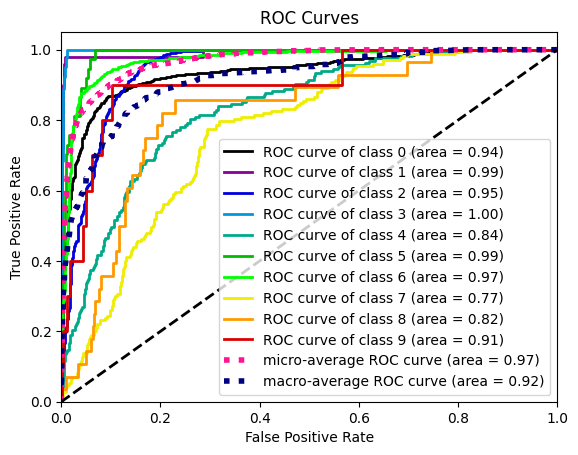

0.9158217666138624


In [979]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

verifica overfitting

Performance sul Training set:
Accuracy: 0.7642
F1 Score: 0.7361

Performance sul Validation set:
Accuracy: 0.7730
F1 Score: 0.7462


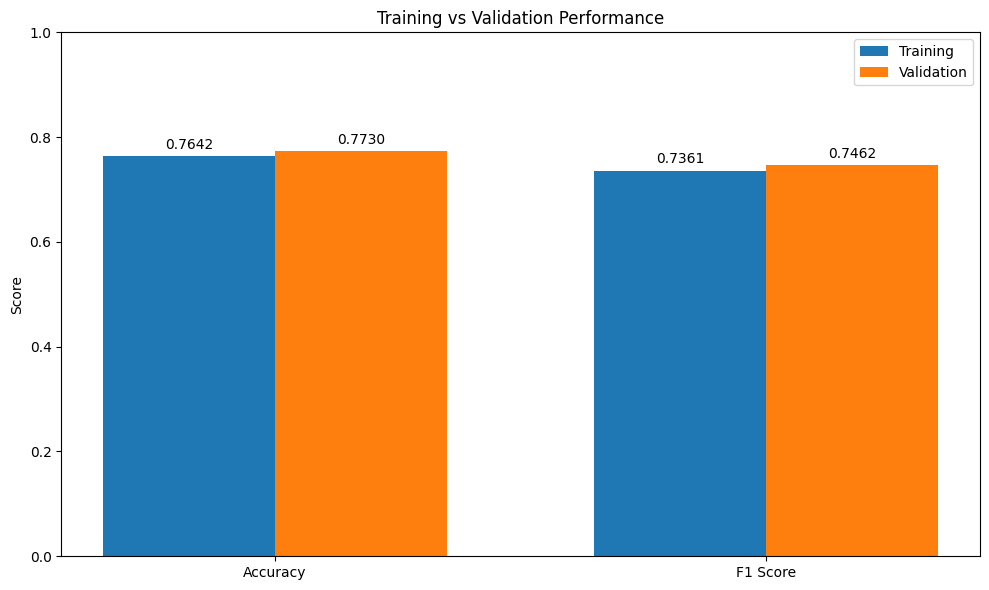

In [980]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Distribuzioni classi nel train set
- classi con < support sono quelle con performance peggiori
- calitare se togliere classi (togliendo 7,8,9 migliora molto)

In [981]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3762
1     209
2    4414
3    1107
4     629
5     187
6    1973
7     695
8     138
9      30
Name: count, dtype: int64


confusion matrix 

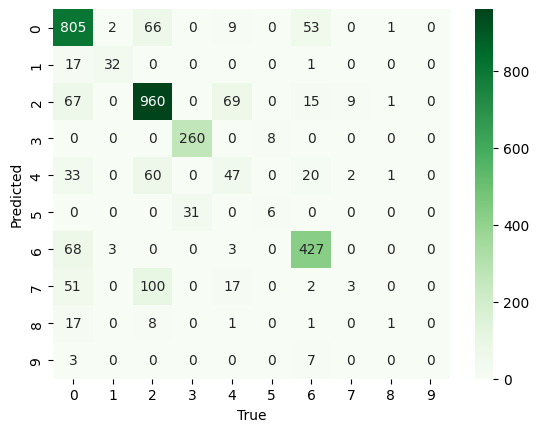

In [982]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

## Proper testing on the test set

In [983]:
##clf = GaussianNB()
##clf.fit(X_train_tr, y_train)
## y_tpred = clf.predict(X_test_tr)
## y_tpred

In [984]:
# # Importazioni necessarie (se non già importate)
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Valutazione sul training set
# y_pred_train = clf.predict(X_train_tr)
# train_accuracy = accuracy_score(y_train, y_pred_train)
# train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# # Valutazione sul test set
# y_pred_test = clf.predict(X_test_tr)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# test_f1 = f1_score(y_test, y_pred_test, average='weighted')
#                         ### gaia ha messo y_tpred

# # Stampa dei risultati
# print(f"Performance sul Training set:")
# print(f"Accuracy: {train_accuracy:.4f}")
# print(f"F1 Score: {train_f1:.4f}")
# print("\nPerformance sul test set:")
# print(f"Accuracy: {test_accuracy:.4f}")
# print(f"F1 Score: {test_f1:.4f}")

# # Visualizzazione grafica del confronto
# metrics = ['Accuracy', 'F1 Score']
# train_scores = [train_accuracy, train_f1]
# test_scores = [test_accuracy, test_f1]

# x = np.arange(len(metrics))
# width = 0.35

# fig, ax = plt.subplots(figsize=(10, 6))
# rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
# rects2 = ax.bar(x + width/2, test_scores, width, label='Validation')

# ax.set_ylabel('Score')
# ax.set_title('Training vs Validation Performance')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.legend()
# ax.set_ylim(0, 1)

# # Aggiungi i valori sopra le barre
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.4f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.tight_layout()
# plt.show()

In [985]:
# print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

In [986]:
# y_test_pred_proba = clf.predict_proba(X_train_tr)
# plot_roc(y_test, y_test_pred_proba)
# plt.show()

In [987]:
# classes_unique = np.unique(y_test)
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
#             xticklabels=classes_unique, 
#             yticklabels=classes_unique)
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.tight_layout()
# plt.show()

#### devo cambiare qualcosa?
Compare the results with a dummy classifier 

In [988]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Create dummy classifier (most frequent class strategy)
# dummy = DummyClassifier(strategy="most_frequent")
# dummy.fit(X_train_tra, y_train)

# # Predict and evaluate
# y_pred = dummy.predict(X_test_tr)

# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))